# Estimation of factor sensitivities

## Data generation

We create a 3 factor model for a return time series. We will take the sensitivities to the factors to be time dependent, with the following shapes:
- A random smooth stationary series.
- A smooth increase, then decrease.
- A step function from 0 to 1. 
The factors themselves will be stationary time series. For now we take them to be random white noise. We could also take them to be smooth functions. In addition there is idiosynchratic component to the returns, which is a white noise too.

## Making the study rigorous

Ideas:
- Parallelize the code.
- We could use non-gaussian noise.
- We could vary the intensity of the noise (but this will require to reestimate the windo of the rolling regression and the covariances of the Kalman filters.


In [36]:
%matplotlib inline
import importlib
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from pyfinance.ols import OLS, RollingOLS, PandasRollingOLS
import pykalman
from pykalman import KalmanFilter
from scipy.interpolate import splrep, splev
import multiprocessing as mp
from functools import partial

import functions_kalman as fk

In [37]:
# Sensitivity type
sens_type = "Random smooth" # "Random walk" # "Various smooth" #c
burn_period = 500
return_noise = 1.0

In [162]:
# Strategy parameters
if sens_type == "Random walk":
    # Rolling window for ols regression
    rolling_ols_window = 400
    # Lambda parameter for exponentially weighted ols regression
    exp_rolling_ols_lambda = 0.005
    # Transition covariance/observatiaion covariance for the Kalman filter 
    kalman_covariance_ratio = 0.00002
    # "Momentum" for the naive trend Kalman filter
    nt_factor = 0.5
    # Rolling window over which to compute the momentum
    nt_window = 100
    # Transition covariance/observation covariance for the stochastic trend Kalman filter.
    stkf_covariance_ratio = 2e-10
elif sens_type == "Various smooth":
    rolling_ols_window = 200
    exp_rolling_ols_lambda = 0.01
    kalman_covariance_ratio = 0.0001
    stkf_covariance_ratio = 1e-9
    nt_factor = 0.5
    nt_window = 100
elif sens_type == "Random smooth":
    if return_noise == 1.0
        # Weighted accuracy optimized 
        rolling_ols_window = 100
        exp_rolling_ols_lambda=0.02 #0.005
        kalman_covariance_ratio = 2e-4
        stkf_covariance_ratio = 5e-9
        nt_factor = 0.5
        nt_window = 100
        """
        # MSE optimized
        rolling_ols_window = 100
        exp_rolling_ols_lambda=0.02 #0.005
        kalman_covariance_ratio = 5e-4
        stkf_covariance_ratio = 1e-8
        nt_factor = 0.5
        nt_window = 100
        """

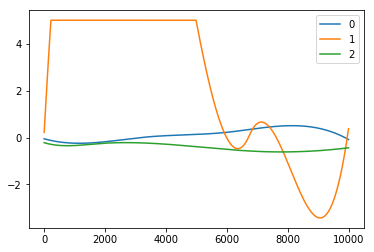

In [39]:
# Sensitivities
timespan = 10000
sens = fk.get_sensitivities(timespan, sens_type)
sens.plot()

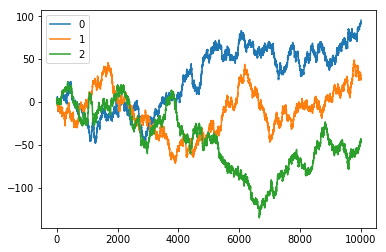

In [40]:
# Factors
factors = fk.get_factors(timespan)
factors.cumsum(axis=0).plot()

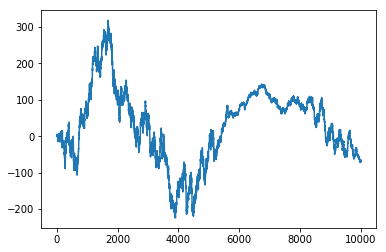

In [41]:
# Returns
returns = fk.get_returns(timespan, factors, sens, return_noise)
returns.cumsum().plot()

In [42]:
# Dictionaries to record the mse and the weighted accuracy
performance_record_mse = {}
performance_record_wacc = {}
# To have consistent colors in the plots
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

## Constant regression

In [43]:
estimated_sensitivities_cr = fk.estimate_sensitivities_cr(factors, returns)
estimated_sensitivities_cr

,0,1,2
0,0.145378,2.201355,-0.440991
1,0.145378,2.201355,-0.440991
2,0.145378,2.201355,-0.440991
3,0.145378,2.201355,-0.440991
4,0.145378,2.201355,-0.440991
5,0.145378,2.201355,-0.440991
6,0.145378,2.201355,-0.440991
7,0.145378,2.201355,-0.440991
8,0.145378,2.201355,-0.440991
9,0.145378,2.201355,-0.440991


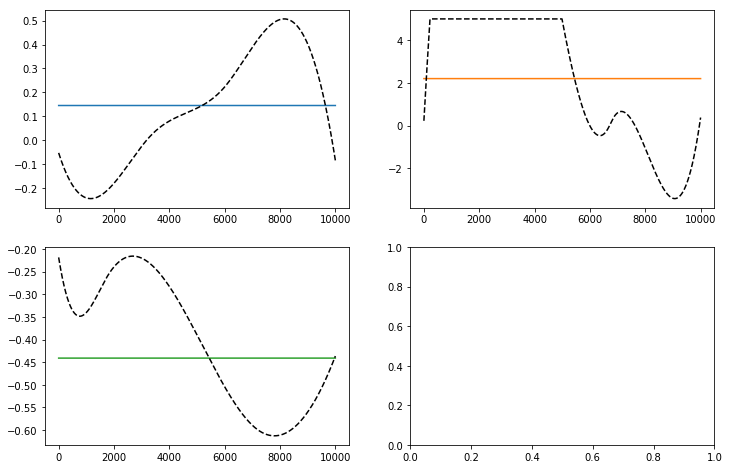

In [44]:
fk.plot_estimated_sensitivities(sens, estimated_sensitivities_cr, colors)

MSE for Constant OLS, assuming the factors known: 10.534662460326448
Weighted accuracy for Constant OLS, assuming the factors known: 1.781908936759071


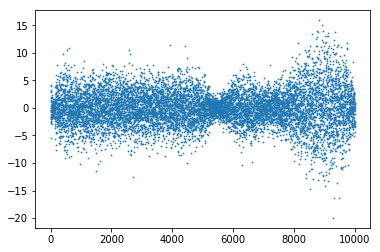

In [45]:
fk.plot_prediction_performance(factors, returns, estimated_sensitivities_cr, "Constant OLS", 
                            performance_record_mse, performance_record_wacc)

## Rolling regression

In [46]:
window = rolling_ols_window
estimated_sensitivities_rr = fk.estimate_sensitivities_rr(factors, returns, window)
estimated_sensitivities_rr

,0,1,2
99,0.003684,1.440809,-0.444736
100,0.021925,1.438058,-0.448769
101,0.006399,1.453640,-0.432327
102,0.015055,1.471819,-0.436397
103,-0.022914,1.569433,-0.468960
104,-0.029114,1.573344,-0.473988
105,-0.042256,1.621045,-0.523473
106,-0.043351,1.620303,-0.524039
107,-0.049815,1.628900,-0.526666
108,-0.066795,1.653973,-0.516743


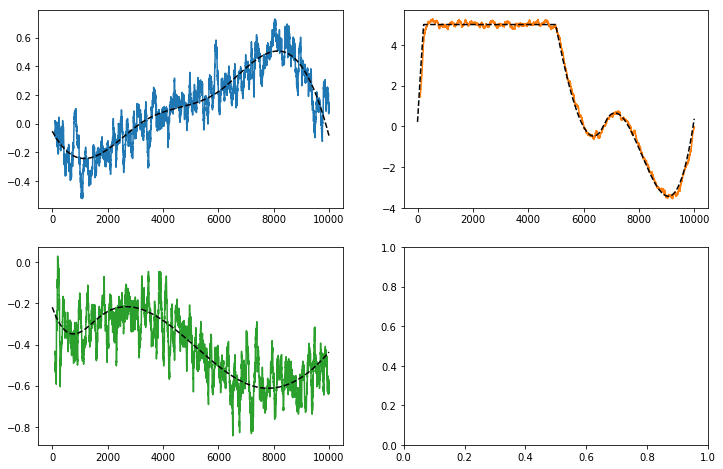

In [47]:
fk.plot_estimated_sensitivities(sens, estimated_sensitivities_rr, colors)

MSE for Rolling OLS, assuming the factors known: 1.077927690585236
Weighted accuracy for Rolling OLS, assuming the factors known: 2.6882144513434456


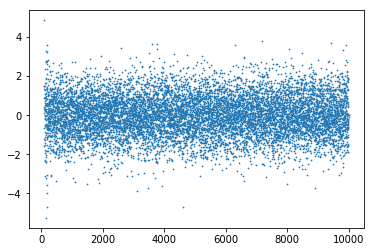

In [48]:
fk.plot_prediction_performance(factors.iloc[window-1:,:], 
                               returns.iloc[window-1:], 
                               estimated_sensitivities_rr, 
                               "Rolling OLS",
                               performance_record_mse,
                               performance_record_wacc)

## Exponential rolling regression

In [49]:
estimated_sensitivities_err = fk.estimate_sensitivities_err(factors, returns, exp_rolling_ols_lambda)

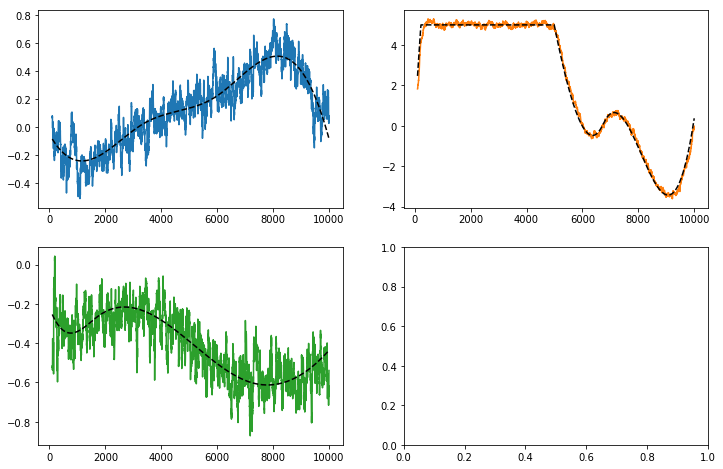

In [50]:
fk.plot_estimated_sensitivities(sens.iloc[100:,:], estimated_sensitivities_err.iloc[100:,:], colors)

MSE for Exponential rolling OLS, assuming the factors known: 1.0547600433141555
Weighted accuracy for Exponential rolling OLS, assuming the factors known: 2.639462691278634


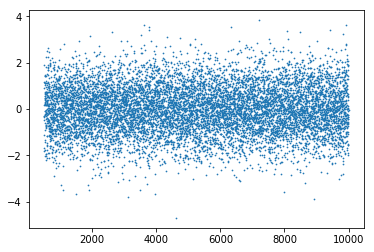

In [51]:
fk.plot_prediction_performance(factors.iloc[burn_period:,:], 
                               returns.iloc[burn_period:], 
                               estimated_sensitivities_err.iloc[burn_period:,:], 
                               "Exponential rolling OLS",
                               performance_record_mse,
                               performance_record_wacc)

## Kalman filter

In [52]:
covariance_ratio = kalman_covariance_ratio
estimated_sensitivities_kf = fk.estimate_sensitivities_kf(factors, returns, covariance_ratio)
estimated_sensitivities_kf

,0,1,2
0,-0.012876,-0.021336,-0.112293
1,0.563232,-0.355765,-0.262888
2,0.546702,0.169433,-0.377278
3,0.511819,0.231185,-0.386955
4,0.798889,0.317958,-0.394207
5,0.679434,0.196287,-0.214761
6,0.927437,0.313017,-0.237150
7,0.968196,0.388369,-0.219472
8,1.000115,0.408029,-0.236893
9,0.986849,0.402493,-0.237254


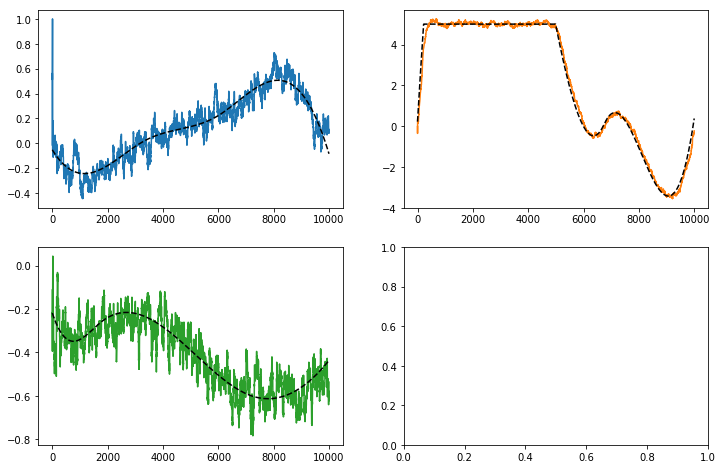

In [53]:
fk.plot_estimated_sensitivities(sens, estimated_sensitivities_kf, colors)

MSE for Kalman, assuming the factors known: 1.0595686673083902
Weighted accuracy for Kalman, assuming the factors known: 2.637963853393122


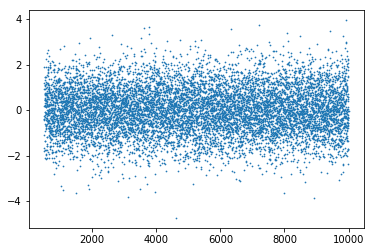

In [54]:
fk.plot_prediction_performance(factors.iloc[burn_period:,:], 
                               returns.iloc[burn_period:], 
                               estimated_sensitivities_kf.iloc[burn_period:,:], 
                               "Kalman",
                               performance_record_mse,
                               performance_record_wacc)

In [55]:
# Naive trend correction...
trend_factor = .5
window = 100
estimated_sensitivities_kf_ntc = fk.estimate_sensitivities_ntc(estimated_sensitivities_kf, trend_factor, window)
estimated_sensitivities_kf_ntc

,0,1,2
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN
7,NaN,NaN,NaN
8,NaN,NaN,NaN
9,NaN,NaN,NaN


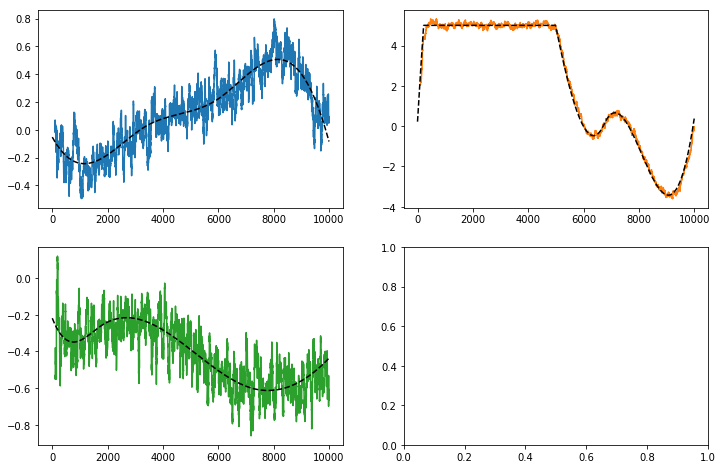

In [56]:
fk.plot_estimated_sensitivities(sens, estimated_sensitivities_kf_ntc, colors)

MSE for Kalman naive trend, assuming the factors known: 1.0576629807587021
Weighted accuracy for Kalman naive trend, assuming the factors known: 2.639071682380232


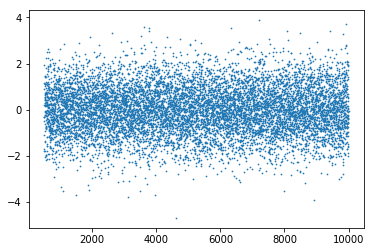

In [57]:
fk.plot_prediction_performance(factors.iloc[burn_period:,:], 
                               returns.iloc[burn_period:], 
                               estimated_sensitivities_kf_ntc.iloc[burn_period:,:], 
                               "Kalman naive trend",
                               performance_record_mse,
                               performance_record_wacc)

## Stochastic trend Kalman filter

In [58]:
importlib.reload(fk)
estimated_sensitivities_stkf = fk.estimate_sensitivities_stkf(factors, returns, stkf_covariance_ratio)
estimated_sensitivities_stkf

,0,1,2
0,-0.012876,-0.021336,-0.112293
1,0.473976,-0.492669,-0.997165
2,0.615389,-0.108509,-2.072078
3,0.906087,-0.203811,-2.985730
4,3.186972,0.727969,-2.687120
5,0.863282,0.519471,0.380865
6,1.038089,0.674449,0.533910
7,1.237075,0.676974,0.617859
8,1.619617,0.935449,0.455036
9,0.500014,0.710018,0.337335


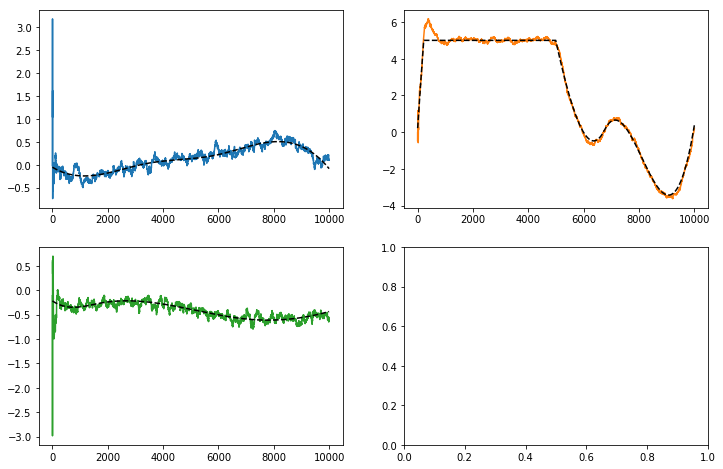

In [59]:
fk.plot_estimated_sensitivities(sens, estimated_sensitivities_stkf, colors)

MSE for Kalman stoch trend, assuming the factors known: 1.042691378937671
Weighted accuracy for Kalman stoch trend, assuming the factors known: 2.6418868293485818


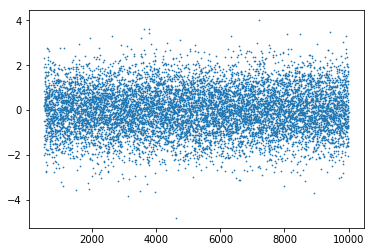

In [60]:
fk.plot_prediction_performance(factors.iloc[burn_period:,:], 
                               returns.iloc[burn_period:], 
                               estimated_sensitivities_stkf.iloc[burn_period:,:], 
                               "Kalman local trend",
                               performance_record_mse,
                               performance_record_wacc)

## Performance summary

In [61]:
pd.Series(performance_record_mse).sort_values()

Kalman stoch trend          1.042691
Exponential rolling OLS     1.054760
Kalman naive trend          1.057663
Kalman                      1.059569
Rolling OLS                 1.077928
Constant OLS               10.534662
dtype: float64

In [62]:
pd.Series(performance_record_wacc).sort_values(ascending=False)

Rolling OLS                2.688214
Kalman stoch trend         2.641887
Exponential rolling OLS    2.639463
Kalman naive trend         2.639072
Kalman                     2.637964
Constant OLS               1.781909
dtype: float64

## Optimisation of the hyperparameters

### Rolling OLS

In [137]:
importlib.reload(fk)
performance_record_mse, performance_record_wacc = fk.compare_hyperparameters_mp("Rolling OLS", 
                                                                             1000,
                                                                             timespan,
                                                                             sens_type,
                                                                             return_noise,
                                                                             rolling_ols_window=[50, 100, 200, 300],
                                                                             )

0
6
3
2
1
5
4
7
8
9
10
11
12
13
14
15
16
17
18
19
21
20
22
23
24
25
26
27
29
28
30
31
32
33
34
35
37
36
38
39
41
40
42
43
45
47
44
46
48
49
52
50
51
54
53
55
56
57
58
59
60
62
63
61
64
65
66
67
68
69
71
70
72
73
74
76
77
75
79
80
81
83
82
78
84
85
88
86
87
89
91
90
93
92
94
95
96
97
98
99
100
103
101
102
104
106
105
107
108
109
110
112
111
115
114
113
116
117
118
119
120
121
123
124
125
122
126
127
128
129
131
130
132
133
134
135
137
136
138
141
140
139
143
142
144
145
146
149
147
150
148
152
151
153
154
155
156
157
158
159
161
160
162
163
165
166
164
167
168
169
170
171
172
174
175
173
176
177
178
180
179
181
182
183
184
186
185
187
188
192
190
191
189
193
194
195
196
198
197
200
199
201
202
203
204
205
206
208
209
207
210
211
215
212
213
214
216
217
218
219
221
220
222
224
223
225
226
227
228
229
230
231
232
233
234
237
236
235
239
238
240
242
241
243
244
247
248
245
249
250
246
251
253
252
254
255
256
257
258
259
260
261
262
263
265
266
264
267
268
269
270
272
271
274
273
275
276
27

In [138]:
performance_record_mse.describe()

,Rolling OLS - {'rolling_ols_window': 100},Rolling OLS - {'rolling_ols_window': 200},Rolling OLS - {'rolling_ols_window': 300},Rolling OLS - {'rolling_ols_window': 50}
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.063441,1.105927,1.177742,1.078704
std,0.089799,0.213734,0.355339,0.040421
min,0.984281,0.975692,0.973736,1.019617
25%,1.029607,1.022484,1.027464,1.060659
50%,1.044213,1.044340,1.061604,1.073103
75%,1.066942,1.110873,1.197301,1.087246
max,2.272797,3.817073,5.486164,1.587709


In [139]:
importlib.reload(fk)
fk.compute_t_stat(performance_record_mse)

Rolling OLS - {'rolling_ols_window': 100}     0.000000
Rolling OLS - {'rolling_ols_window': 200}    10.576501
Rolling OLS - {'rolling_ols_window': 300}    13.340506
Rolling OLS - {'rolling_ols_window': 50}      9.187343
dtype: float64

### Exponential rolling OLS

In [143]:
performance_record_mse, performance_record_wacc = fk.compare_hyperparameters_mp("Exponential rolling OLS", 
                                                    1000, timespan,
                                                    sens_type, return_noise, 
                                                    exp_rolling_ols_lambda=[0.0005, 0.001, 0.002, 0.005, 0.01])

KeyboardInterrupt: 

In [145]:
performance_record_mse.describe()

,Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.002},Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.005},Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.01},Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.02},Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.05}
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.638720,1.202572,1.085558,1.055281,1.086333
std,0.927261,0.340752,0.140801,0.056148,0.022343
min,1.004207,0.977218,0.975261,0.987741,1.033924
25%,1.131188,1.040326,1.022908,1.029346,1.072529
50%,1.302231,1.082086,1.041715,1.042590,1.084744
75%,1.731171,1.216811,1.087745,1.058744,1.096100
max,9.107310,4.186835,2.244070,1.510877,1.242585


In [144]:
fk.compute_t_stat(performance_record_mse)

Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.002}     0.000000
Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.005}   -22.975888
Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.01}    -21.903765
Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.02}    -20.962354
Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.05}    -19.093360
dtype: float64

### Kalman

In [149]:
performance_record_mse, performance_record_wacc = fk.compare_hyperparameters_mp("Kalman", 1000, timespan,
                                                    sens_type, return_noise, 
                                                    kalman_covariance_ratio=[1e-4, 2e-4, 5e-4, 1e-3, 2e-3])

6
0
1
2
3
4
5
9
7
8
12
11
10
13
14
16
15
17
18
20
19
21
22
23
24
25
26
27
29
28
31
30
33
32
34
36
35
38
39
37
41
40
48
43
42
44
45
47
46
49
50
51
54
55
52
53
59
56
62
58
57
61
60
64
63
66
65
67
68
69
70
71
74
72
75
73
76
77
78
80
82
79
81
83
84
85
88
86
87
89
90
95
96
92
91
94
93
97
98
100
99
104
103
102
101
106
105
108
111
107
110
109
112
118
116
114
115
113
117
119
124
120
123
121
122
125
126
131
127
132
128
129
130
133
135
134
136
137
139
138
140
143
144
145
141
142
146
147
152
149
148
153
150
151
154
156
157
155
159
160
158
161
162
163
164
166
165
167
168
169
170
171
172
173
174
176
175
177
178
179
180
181
183
182
184
185
187
186
188
189
190
191
192
193
194
195
196
197
199
198
200
201
202
204
203
205
206
207
208
209
210
211
213
214
212
215
216
218
217
219
221
220
222
223
225
224
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
270
269
271
273
274
272
275
276
27

In [153]:
performance_record_mse.describe()

,Kalman - {'kalman_covariance_ratio': 0.0001},Kalman - {'kalman_covariance_ratio': 0.0002},Kalman - {'kalman_covariance_ratio': 0.0005},Kalman - {'kalman_covariance_ratio': 0.001},Kalman - {'kalman_covariance_ratio': 0.002}
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.084579,1.062417,1.054181,1.059805,1.074631
std,0.151451,0.101408,0.060947,0.043018,0.032013
min,0.978161,0.982597,0.986103,0.996080,1.012759
25%,1.021303,1.022382,1.030123,1.041469,1.059497
50%,1.042583,1.039091,1.043631,1.054071,1.071506
75%,1.085900,1.064010,1.061027,1.069169,1.084387
max,3.344782,2.733833,2.174038,1.891254,1.694521


In [151]:
fk.compute_t_stat(performance_record_mse)

Kalman - {'kalman_covariance_ratio': 0.0001}     0.000000
Kalman - {'kalman_covariance_ratio': 0.0002}   -13.484864
Kalman - {'kalman_covariance_ratio': 0.0005}   -10.196609
Kalman - {'kalman_covariance_ratio': 0.001}     -6.904865
Kalman - {'kalman_covariance_ratio': 0.002}     -2.500040
dtype: float64

### Kalman naive trend

In [116]:
performance_record_mse, performance_record_wacc = fk.compare_hyperparameters_mp("Kalman naive trend", 1000, timespan,
                                                    sens_type, return_noise, kalman_covariance_ratio=[2e-4],
                                                               nt_factor=[.1, .2, .5, 1.0, 2.0], 
                                                               nt_window=[100])

1
6
5
4
2
0
3
8
7
12
10
9
11
13
16
14
15
17
19
18
20
22
26
24
21
23
25
27
28
29
31
32
34
30
33
35
36
37
40
38
39
41
43
42
45
44
48
46
47
50
49
52
51
54
55
53
56
57
58
62
61
59
60
63
64
67
66
68
65
69
71
70
72
74
75
73
76
78
77
79
80
81
82
83
84
85
86
89
87
88
90
91
92
93
94
97
96
95
98
99
100
101
103
102
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
129
128
131
130
132
133
134
136
135
137
138
139
140
141
142
143
146
145
144
147
148
149
150
152
151
153
154
155
156
157
159
160
158
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
187
186
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
215
213
214
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
240
239
241
243
242
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
275
274
278
27

In [117]:
performance_record_wacc.describe()

,"Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 0.1, 'nt_window': 100}","Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 0.2, 'nt_window': 100}","Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 0.5, 'nt_window': 100}","Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 1.0, 'nt_window': 100}","Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 2.0, 'nt_window': 100}"
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.408019,1.407975,1.407087,1.403553,1.390004
std,0.849996,0.850584,0.852379,0.855034,0.859860
min,0.240860,0.238267,0.228548,0.217261,0.185826
25%,0.772805,0.772173,0.770917,0.764832,0.747149
50%,1.141486,1.141871,1.140500,1.137410,1.125027
75%,1.809668,1.810137,1.810830,1.808977,1.804566
max,4.916825,4.920530,4.927479,4.929958,4.922108


In [118]:
fk.compute_t_stat(performance_record_wacc)

Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 0.1, 'nt_window': 100}          NaN
Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 0.2, 'nt_window': 100}    -0.872191
Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 0.5, 'nt_window': 100}    -6.271019
Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 1.0, 'nt_window': 100}   -16.798451
Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 2.0, 'nt_window': 100}   -41.849886
dtype: float64


### Kalman stochastic trend

In [159]:
performance_record_mse, performance_record_wacc = fk.compare_hyperparameters_mp("Kalman local trend", 1000, timespan,
                                                    sens_type, return_noise, stkf_covariance_ratio=[1e-9, 2e-9, 5e-9, 1e-8, 2e-8])

6
5
3
4
1
2
0
7
8
10
9
11
12
13
15
16
14
17
19
18
20
21
22
23
24
25
26
27
28
30
29
31
32
33
34
35
36
37
38
39
40
41
42
43
46
45
44
47
48
49
50
51
52
53
54
55
56
57
59
58
60
61
62
63
64
66
65
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
87
86
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
114
113
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
136
135
137
138
139
140
141
143
142
144
145
146
148
147
149
150
151
152
153
154
155
156
157
158
159
160
162
163
164
161
166
165
167
168
169
170
171
172
173
174
175
176
177
178
180
179
181
183
182
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
223
222
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
243
242
244
245
246
247
248
249
250
251
252
253
254
255
257
256
258
260
259
261
262
264
263
265
266
267
268
269
271
270
272
274
273
275
276
27

In [160]:
performance_record_mse.describe()

,Kalman local trend - {'stkf_covariance_ratio': 1e-08},Kalman local trend - {'stkf_covariance_ratio': 1e-09},Kalman local trend - {'stkf_covariance_ratio': 2e-08},Kalman local trend - {'stkf_covariance_ratio': 2e-09},Kalman local trend - {'stkf_covariance_ratio': 5e-09}
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.054204,1.081546,1.054747,1.067240,1.057001
std,0.070567,0.170809,0.055010,0.130453,0.091577
min,0.983501,0.972052,0.989028,0.974390,0.978983
25%,1.027475,1.018241,1.032776,1.019473,1.023140
50%,1.039157,1.031792,1.044575,1.032673,1.035400
75%,1.054977,1.062865,1.058191,1.054778,1.053089
max,1.722671,2.827765,1.557688,2.407503,1.966761


In [161]:
fk.compute_t_stat(performance_record_mse)

Kalman local trend - {'stkf_covariance_ratio': 1e-08}    0.000000
Kalman local trend - {'stkf_covariance_ratio': 1e-09}    8.257560
Kalman local trend - {'stkf_covariance_ratio': 2e-08}    1.025684
Kalman local trend - {'stkf_covariance_ratio': 2e-09}    6.548750
Kalman local trend - {'stkf_covariance_ratio': 5e-09}    3.970021
dtype: float64

## Systematic analysis

We want to run the experiment above a large number of times to gather statistics on the performance of the regression estimators.

In [163]:
importlib.reload(fk)
num_samples = 10000
algo_parameters = {'rolling_ols_window': rolling_ols_window,
                   'exp_rolling_ols_lambda': exp_rolling_ols_lambda,
                   'kalman_covariance_ratio': kalman_covariance_ratio,
                   'stkf_covariance_ratio': stkf_covariance_ratio,
                  }
performance_record_mse, performance_record_wacc = fk.get_performance_data(num_samples, 
                                                              sens_type, timespan, return_noise, algo_parameters)

1
0
2
3
6
5
4
11
9
7
8
13
10
12
15
16
14
19
20
18
17
22
24
25
26
27
21
23
29
34
28
30
32
31
33
41
38
36
37
39
40
35
45
42
43
44
47
46
48
50
51
49
52
55
54
53
56
58
57
62
59
61
60
63
64
65
66
69
68
67
70
76
73
71
75
74
72
80
82
78
81
79
77
83
84
87
86
85
89
88
90
91
92
95
96
93
94
97
98
100
101
99
102
104
103
105
106
107
108
110
109
111
112
113
114
116
117
115
118
119
120
121
122
123
124
125
126
132
128
127
129
131
130
133
135
137
139
138
136
134
145
144
143
141
142
140
146
147
148
150
149
151
153
152
154
155
157
156
159
160
158
163
161
162
164
165
166
167
169
168
170
174
173
171
172
175
176
177
179
180
181
178
182
183
184
185
186
187
188
189
193
192
190
195
191
194
197
198
196
201
199
202
200
203
204
205
208
206
207
209
211
210
212
213
215
214
216
217
219
221
220
222
218
223
224
225
227
226
229
228
230
231
234
232
235
233
236
237
238
239
243
244
241
240
242
245
246
249
247
251
250
248
252
253
257
258
255
256
254
259
265
261
260
263
262
264
266
272
270
267
268
271
269
273
274
278
276
27

1861
1863
1862
1865
1866
1864
1867
1868
1872
1874
1871
1870
1873
1869
1875
1880
1879
1878
1881
1876
1877
1882
1883
1885
1884
1886
1888
1887
1889
1890
1893
1894
1891
1895
1892
1896
1899
1902
1898
1901
1897
1900
1903
1904
1905
1907
1908
1906
1909
1910
1911
1912
1916
1914
1915
1913
1919
1917
1922
1918
1921
1920
1923
1924
1925
1926
1927
1929
1930
1928
1931
1936
1933
1934
1937
1932
1935
1938
1939
1940
1942
1943
1944
1941
1945
1946
1947
1951
1949
1948
1950
1956
1954
1955
1952
1958
1953
1957
1960
1965
1962
1959
1963
1961
1964
1966
1967
1969
1968
1970
1971
1972
1973
1974
1975
1978
1976
1977
1979
1980
1983
1984
1981
1982
1985
1986
1987
1989
1991
1988
1990
1992
1993
1998
1995
1994
1996
1999
2000
1997
2002
2001
2003
2005
2007
2004
2006
2008
2010
2011
2012
2014
2013
2009
2015
2018
2021
2019
2016
2017
2020
2022
2024
2026
2023
2027
2025
2028
2029
2034
2032
2030
2031
2033
2035
2036
2037
2038
2039
2041
2040
2042
2043
2044
2045
2049
2047
2046
2048
2050
2055
2051
2054
2053
2056
2052
2057
2062
2058
2059


3500
3504
3505
3507
3509
3506
3511
3508
3510
3512
3513
3514
3516
3517
3515
3518
3519
3522
3520
3521
3523
3525
3524
3526
3530
3532
3527
3528
3529
3531
3533
3535
3537
3538
3534
3536
3539
3543
3540
3541
3542
3544
3545
3546
3547
3548
3552
3550
3551
3549
3553
3554
3557
3555
3560
3556
3558
3559
3561
3566
3562
3567
3563
3564
3565
3568
3570
3571
3573
3572
3569
3574
3575
3576
3579
3581
3577
3580
3578
3582
3584
3587
3583
3588
3585
3586
3589
3590
3592
3591
3595
3594
3593
3600
3597
3596
3599
3598
3601
3602
3603
3604
3605
3607
3606
3608
3609
3610
3613
3611
3612
3614
3615
3616
3617
3618
3621
3620
3622
3619
3623
3624
3627
3625
3629
3630
3628
3626
3631
3632
3634
3636
3633
3637
3635
3638
3639
3640
3642
3644
3641
3643
3645
3646
3647
3648
3650
3649
3651
3652
3653
3656
3654
3655
3657
3658
3659
3660
3665
3663
3662
3661
3664
3666
3667
3669
3668
3671
3672
3670
3673
3675
3674
3677
3676
3679
3678
3680
3681
3682
3683
3684
3685
3686
3687
3688
3690
3692
3689
3691
3693
3694
3695
3698
3699
3697
3696
3700
3701
3703


5146
5148
5147
5143
5145
5144
5149
5150
5151
5154
5153
5156
5155
5152
5157
5161
5158
5162
5159
5160
5163
5164
5165
5166
5167
5170
5168
5169
5171
5173
5175
5172
5174
5177
5176
5179
5181
5178
5184
5182
5183
5180
5185
5186
5188
5191
5187
5190
5189
5192
5196
5198
5193
5195
5194
5197
5200
5199
5202
5201
5204
5203
5205
5206
5209
5208
5211
5207
5210
5212
5213
5214
5218
5219
5215
5217
5216
5220
5221
5222
5224
5226
5223
5225
5227
5229
5232
5228
5233
5230
5231
5234
5237
5236
5239
5238
5235
5240
5241
5242
5245
5243
5244
5247
5246
5249
5248
5252
5251
5253
5254
5250
5255
5259
5256
5261
5257
5260
5258
5262
5266
5263
5264
5267
5268
5265
5269
5270
5271
5272
5274
5275
5273
5276
5277
5279
5281
5282
5278
5280
5283
5285
5284
5286
5288
5287
5289
5290
5291
5293
5295
5292
5296
5294
5297
5298
5299
5301
5303
5300
5302
5305
5304
5307
5306
5309
5310
5308
5311
5312
5317
5314
5315
5313
5316
5318
5320
5323
5319
5322
5324
5321
5325
5326
5329
5327
5331
5328
5330
5332
5336
5334
5337
5338
5333
5335
5339
5340
5345
5342


6785
6782
6783
6786
6787
6788
6789
6791
6792
6794
6793
6790
6795
6796
6797
6798
6800
6799
6801
6806
6802
6803
6804
6805
6807
6808
6809
6810
6811
6813
6815
6814
6812
6816
6817
6822
6820
6819
6818
6821
6823
6824
6825
6827
6829
6826
6828
6830
6834
6836
6831
6832
6835
6833
6841
6840
6837
6839
6843
6842
6838
6844
6846
6847
6849
6850
6848
6845
6851
6852
6857
6853
6855
6856
6854
6858
6859
6861
6860
6864
6862
6863
6865
6866
6868
6867
6871
6870
6869
6872
6875
6873
6877
6878
6876
6874
6879
6884
6880
6885
6881
6882
6883
6887
6888
6886
6891
6890
6889
6892
6893
6894
6895
6896
6898
6899
6897
6900
6905
6902
6901
6903
6904
6906
6907
6908
6910
6909
6911
6913
6912
6914
6916
6920
6915
6917
6919
6918
6921
6922
6926
6925
6924
6927
6923
6928
6930
6931
6932
6933
6929
6934
6937
6940
6938
6935
6936
6941
6939
6943
6942
6944
6946
6947
6948
6945
6949
6952
6951
6955
6954
6950
6953
6956
6957
6959
6961
6958
6960
6962
6963
6966
6964
6965
6967
6968
6969
6970
6971
6973
6972
6974
6976
6975
6977
6978
6979
6981
6982
6980


8422
8426
8430
8431
8427
8429
8428
8432
8433
8435
8434
8437
8439
8436
8438
8443
8441
8440
8446
8444
8445
8442
8447
8449
8448
8453
8451
8450
8452
8454
8455
8456
8459
8457
8460
8458
8461
8462
8463
8465
8467
8466
8464
8468
8469
8471
8470
8474
8472
8473
8475
8476
8480
8478
8477
8481
8479
8482
8486
8485
8488
8483
8487
8484
8489
8490
8492
8495
8493
8491
8494
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8507
8506
8509
8508
8511
8510
8513
8512
8515
8516
8514
8518
8517
8520
8519
8521
8522
8523
8526
8524
8525
8529
8527
8530
8528
8533
8531
8532
8534
8535
8537
8536
8542
8538
8543
8541
8540
8544
8539
8545
8546
8549
8548
8550
8547
8551
8552
8553
8556
8557
8558
8555
8554
8559
8560
8564
8565
8561
8563
8562
8567
8568
8566
8572
8571
8569
8570
8574
8573
8578
8575
8579
8577
8576
8580
8581
8583
8582
8584
8586
8585
8588
8587
8591
8593
8589
8590
8592
8600
8597
8596
8595
8599
8594
8598
8606
8602
8604
8605
8601
8603
8607
8608
8610
8609
8612
8613
8614
8611
8615
8616
8617
8620
8621
8619
8618
8622
8623
8624


In [164]:
performance_record_wacc.describe()

,Constant OLS,Exponential rolling OLS,Kalman,Kalman local trend,Oracle,Rolling OLS
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.829536,1.375504,1.375129,1.376336,1.386528,1.375023
std,0.697193,0.858285,0.858841,0.858706,0.857622,0.858011
min,-0.142187,0.221277,0.221004,0.221659,0.259002,0.225446
25%,0.375252,0.754287,0.753254,0.755183,0.766102,0.754788
50%,0.592367,1.066036,1.065530,1.066792,1.076458,1.066556
75%,1.033106,1.754102,1.755000,1.755625,1.764166,1.753625
max,4.838214,5.357505,5.357572,5.360668,5.360524,5.356906


ValueError: Illegal argument(s) to subplot: (3, 2)

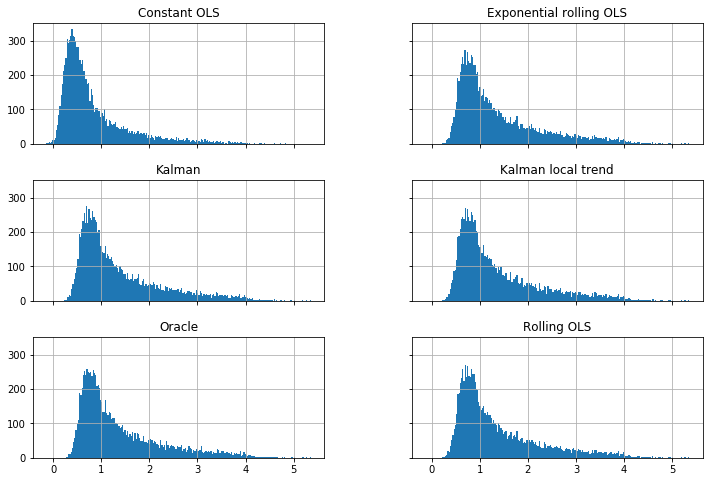

In [165]:
axes = performance_record_wacc.iloc[:,0:].hist(bins=200, sharex=True, sharey=True, figsize=(12,8))
fig, axes = plt.subplot(3,2)

In [166]:
importlib.reload(fk)
import warnings
warnings.filterwarnings('ignore')
fk.performance_summary(performance_record_wacc, "Weighted accuracy")
#fk.performance_summary(performance_record_wacc.drop('Constant OLS', axis=1), "Weighted accuracy")

,Weighted accuracy,t-test differential p-value,Wilcoxon test differential p-value
Oracle,1.386528,0.000000e+00,0.000000e+00
Kalman local trend,1.376336,5.179057e-102,1.863135e-141
Exponential rolling OLS,1.375504,2.491883e-110,2.833864e-146
Kalman,1.375129,1.203498e-02,9.917602e-02
Rolling OLS,1.375023,0.000000e+00,0.000000e+00
Constant OLS,0.829536,NaN,NaN


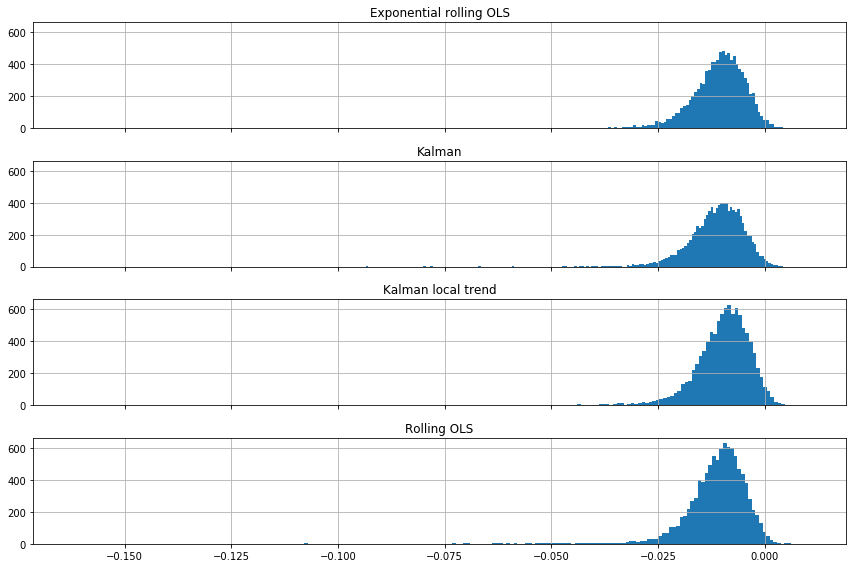

In [167]:
importlib.reload(fk)
fk.plot_perf_differences(performance_record_wacc.iloc[:,1:], reference='Oracle')

In [168]:
performance_record_mse.describe()

,Constant OLS,Exponential rolling OLS,Kalman,Kalman local trend,Oracle,Rolling OLS
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.418865,1.055441,1.055109,1.055380,1.000603,1.059443
std,4.175151,0.063558,0.057064,0.089309,0.015130,0.078244
min,1.047585,0.983166,0.985041,0.977927,0.944200,0.983556
25%,1.717446,1.028318,1.030480,1.025906,0.990156,1.029313
50%,2.634042,1.041901,1.043658,1.038235,1.000483,1.042915
75%,5.755506,1.059591,1.060527,1.053636,1.010731,1.060949
max,40.934158,2.222612,2.102877,2.757602,1.063673,2.537323


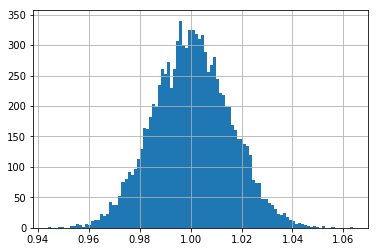

In [169]:
performance_record_mse.iloc[:,4].hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000441E90F0>,
      dtype=object)

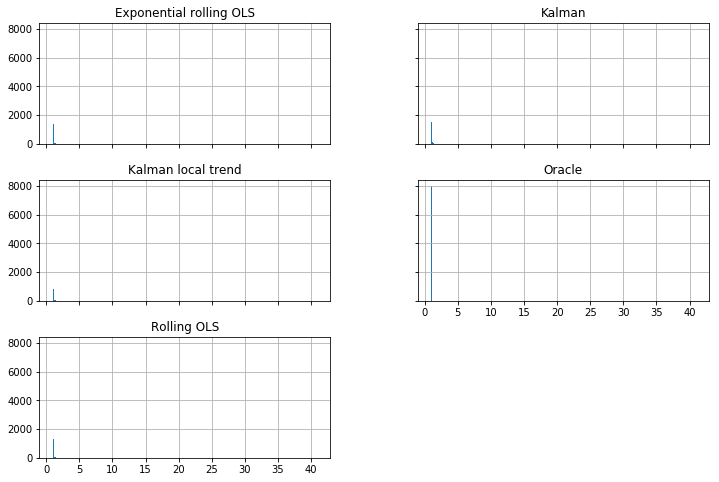

In [170]:
bins=np.histogram(performance_record_mse, bins=1000)[1]
performance_record_mse.iloc[:,1:].hist(bins=bins, sharex=True, sharey=True, figsize=(12,8))

In [171]:
fk.performance_summary(performance_record_mse, "MSE")

,MSE,t-test differential p-value,Wilcoxon test differential p-value
Oracle,1.000603,0.000000e+00,0.0
Kalman,1.055109,4.539085e-01,0.0
Kalman local trend,1.055380,8.451574e-01,0.0
Exponential rolling OLS,1.055441,1.567261e-126,0.0
Rolling OLS,1.059443,0.000000e+00,0.0
Constant OLS,4.418865,NaN,NaN


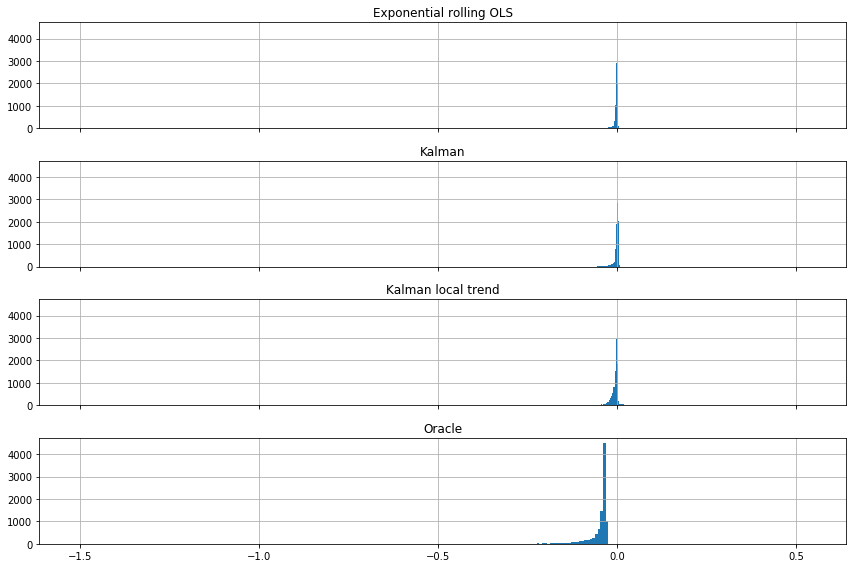

In [172]:
fk.plot_perf_differences(performance_record_mse.iloc[:,1:], reference='Rolling OLS')

## Save data

In [173]:
import pickle
with open('20190331-performance_record-opt_mse.pickle', 'wb') as f:
    pickle.dump({"Weighted accuracy": performance_record_wacc, "MSE": performance_record_mse}, f)

In [129]:
with open('20190314-performance_record.pickle', 'rb') as f:
    ls = pickle.load(f)
performance_record_wacc = ls['Weighted accuracy']
performance_record_mse = ls['MSE'] 

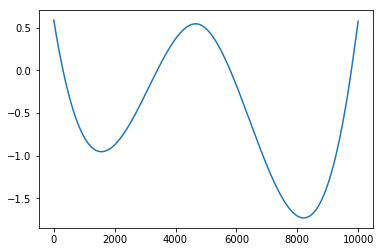

In [747]:
random_sensitivity = create_random_sensitivity(timespan)
#values = splev(factors.index, random_sensitivity)

plt.figure()
random_sensitivity.plot()
#plt.plot(factors.index, values)
plt.show()